<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection-Projects/blob/main/Flower_Recognition_Challenges_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import copy
import time
import tqdm
import torch
import mlxtend
import warnings
import matplotlib
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing

In [3]:
warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#PyTorch-Flowers-TransLearing+Ensemble
[Note Book](https://www.kaggle.com/code/georgiisirotenko/pytorch-flowers-translearing-ensemble-test-99-67)

##1.Get Data

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

**plotImg_Hist**

input: image file , is_path=False

OR

input: image path , is_path=True

output: None

this function, gets image file and plots it's pixel intensity and the image itself.

you can give image path to this function too and expect the same results, but just remmember to set 'is_path=True'


In [4]:
def plotImg_Hist(img, is_path=False):
  if is_path:
    img = matplotlib.image.imread(img)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.axis('off')
  hist = plt.subplot(1, 2, 2)
  hist.set_ylabel('Count')
  hist.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

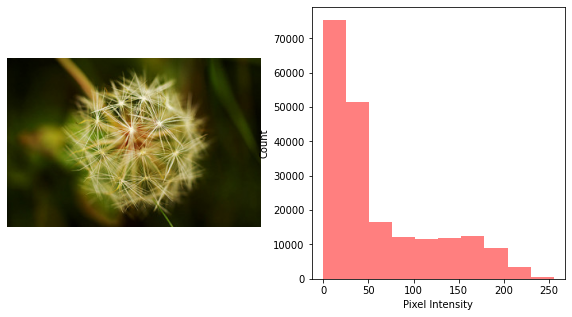

In [5]:
test_img = matplotlib.image.imread('/content/flowers/dandelion/10043234166_e6dd915111_n.jpg')
plotImg_Hist(test_img)

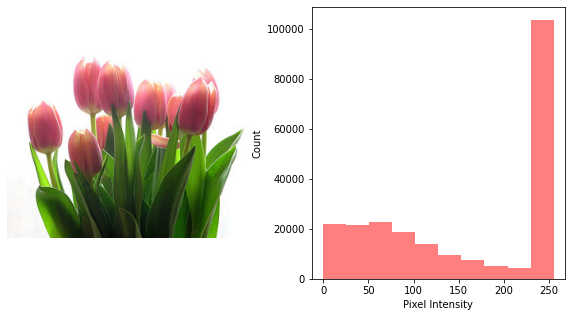

In [6]:
plotImg_Hist('/content/flowers/tulip/112428665_d8f3632f36_n.jpg', is_path=True)

##2.Data Prepration

The "original" dataset is the original dataset and others are some augmentations of it.

In [7]:
mean = (0.4124234616756439, 0.3674212694168091, 0.2578217089176178)
std = (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)
transformer = {
    'original': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset1': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                               torchvision.transforms.RandomRotation(5),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset2': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.RandomRotation(10),
                                               torchvision.transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.RandomErasing(inplace=True, scale=(0.01,  0.23)),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset3': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                               torchvision.transforms.RandomRotation(15),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
}

**pin_memory**: You know how sometimes your GPU memory shows that it’s full but you’re pretty sure that your model isn’t using that much? 

That overhead is called pinned memory. 

ie: this memory has been reserved as a type of “working allocation.” When you enable pinned_memory in a DataLoader it “automatically puts the fetched data Tensors in pinned memory, and enables faster data transfer to CUDA-enabled GPUs”

**num_workers**: PyTorch allows loading data on multiple processes simultaneously. A good rule: num_worker = 4 num_GPU*

In [8]:
path = '/content/flowers/'

#all dataset ==> train&val + test
original = torchvision.datasets.ImageFolder(path, transform=transformer['original'])
train_val, test = model_selection.train_test_split(original, test_size=0.2, random_state=32, shuffle=True)

# train_val  ==> train + val + dataset1 + dataset2 + dataset3
train_val = torch.utils.data.ConcatDataset([train_val,
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset1']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset2']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset3'])])

train, val = model_selection.train_test_split(train_val, test_size=0.1, shuffle=True, random_state=32)

In [9]:
batch_size=32
data_loaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=4, pin_memory=True),
    'test': torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=4, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test)
}

In [10]:
dataset_sizes

{'test': 864, 'train': 14763, 'val': 1641}